In [4]:
import recipe_parser as rp
import search 
import index 
import torch
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer, AutoModelForCausalLM, CLIPTokenizerFast
from datasets import load_dataset
import matplotlib.pyplot as plt



## Clip example


In [4]:


model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

inputs = processor(text=["a photo of a cat", "a photo of a dog"], images=image, return_tensors="pt", padding=True)

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)  # we can take the softmax to get the label probabilities

### Clip config example

In [ ]:
from transformers import CLIPConfig, CLIPModel

# Initializing a CLIPConfig with openai/clip-vit-base-patch32 style configuration
configuration = CLIPConfig()

# Initializing a CLIPModel (with random weights) from the openai/clip-vit-base-patch32 style configuration
model = CLIPModel(configuration)

# Accessing the model configuration
configuration = model.config

# We can also initialize a CLIPConfig from a CLIPTextConfig and a CLIPVisionConfig
from transformers import CLIPTextConfig, CLIPVisionConfig

# Initializing a CLIPText and CLIPVision configuration
config_text = CLIPTextConfig()
config_vision = CLIPVisionConfig()

config = CLIPConfig.from_text_vision_configs(config_text, config_vision)

## PlanLLM

In [5]:

tokenizer = AutoTokenizer.from_pretrained("NOVA-vision-language/PlanLLM")
model = AutoModelForCausalLM.from_pretrained("NOVA-vision-language/PlanLLM")

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/550 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/840 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

model-00001-of-00006.safetensors:   0%|          | 0.00/4.84G [00:00<?, ?B/s]

# Phase 2


## 3.1.1 Cross-model retrieval - Use CLIP for image and text encoding

## Video example


In [42]:

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    ignore_verifications=True #True if seeing splits error
)
imagenette

/Users/joao/anaconda3/envs/nlp-cv-ir/lib/python3.9/site-packages/datasets/load.py:2555: FutureWarning: 'ignore_verifications' was deprecated in favor of 'verification_mode' in version 2.9.1 and will be removed in 3.0.0.
You can remove this warning by passing 'verification_mode=no_checks' instead.
  warnings.warn(


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [29]:

device =  "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using {device}")

model_ID = "openai/clip-vit-base-patch32"

model = CLIPModel.from_pretrained(model_ID).to("mps")
tokenizer = CLIPTokenizerFast.from_pretrained(model_ID)
processor = CLIPProcessor.from_pretrained(model_ID)


Using mps


In [33]:
prompt = "A dog in the snow"
inputs = tokenizer(prompt,return_tensors="pt").to("mps")
inputs

{'input_ids': tensor([[49406,   320,  1929,   530,   518,  2583, 49407]], device='mps:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1]], device='mps:0')}

In [86]:
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [52]:
image = processor(
    text = None,
    images = imagenette[0]['image'],
    return_tensors = "pt",
)['pixel_values'].to("mps")
image.shape

torch.Size([1, 3, 224, 224])

In [53]:
image.squeeze(0).T.shape


torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


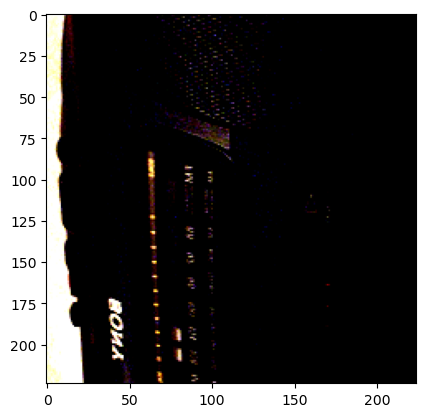

In [57]:
plt.imshow(image.squeeze(0).T.cpu())

In [58]:
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [64]:
import numpy as np

np.random.seed(0)
sample_idx = np.random.randint(0, len(imagenette)+1, 100).tolist()
images = [imagenette[i]['image'] for i in sample_idx]
images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=267x200>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x365>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=216x332>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=375x500>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=250x252>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=320x240>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x333>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=300x225>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x375>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=145x108>,
 <PIL.Imag

In [75]:
from tqdm.auto import tqdm

batch_size = 16
image_arr = None

for i in tqdm(range(0,len(images), batch_size)):
    # Select batch of images 
    batch = images[i:i+batch_size]
    # Process and resize
    batch = processor(
        text = None,
        images = batch, 
        return_tensors = "pt",
        padding = True
    )['pixel_values'].to("mps")
    # get image embeddings
    batch_emb = model.get_image_features(batch)
    # convert to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    # add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)

image_arr.shape
    

  0%|          | 0/7 [00:00<?, ?it/s]

(100, 512)

In [76]:
image_arr.min(), image_arr.max()

(-7.994906, 3.1525123)

In [77]:
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [78]:
image_arr.min(), image_arr.max()

(-0.6996714, 0.3125501)

In [87]:
text_emb = text_emb.cpu().detach().numpy()
scores = np.dot(text_emb, image_arr)

In [89]:
scores.shape

(1, 100)

In [91]:
scores[0].shape

(100,)

In [93]:
top_k = 5
idx = np.argsort(-scores[0]) [:top_k]
idx

array([71, 24, 86, 76, 85])

2.4251523


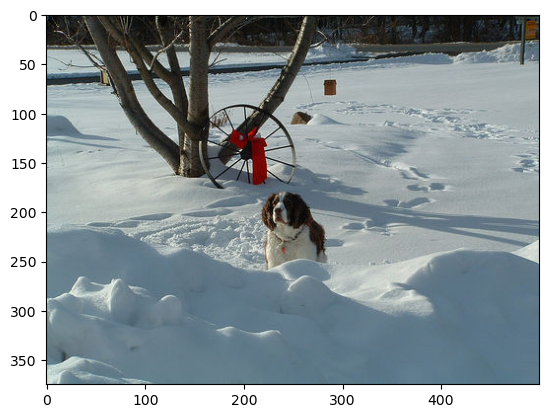

2.2195625


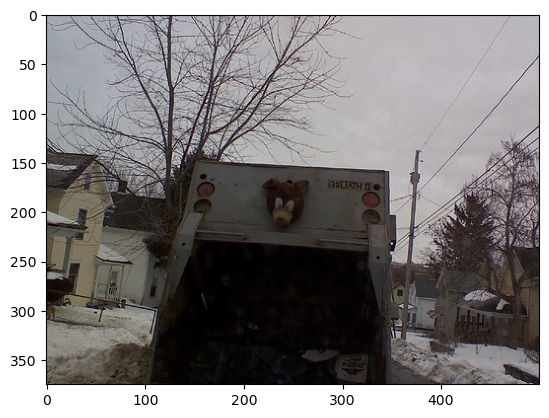

1.8799808


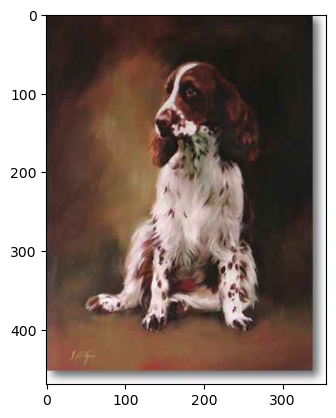

1.7686567


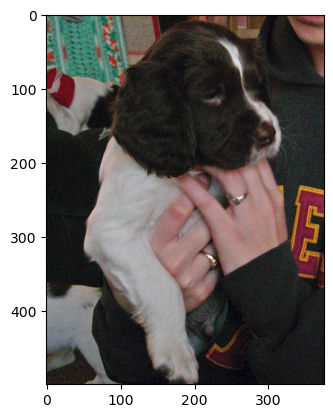

1.7330451


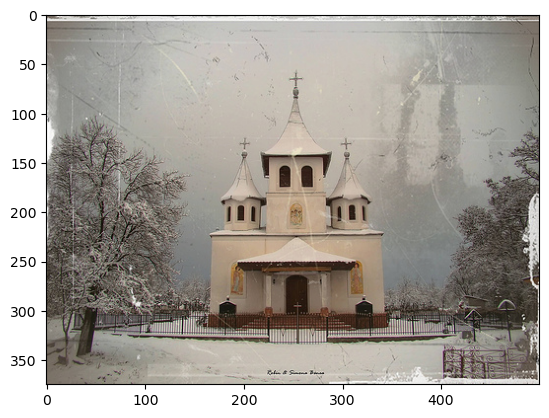

In [94]:
for i in idx:
    print(scores[0][i])
    plt.imshow(images[i])
    plt.show()


## Phase 2 proper

### Recipes images



In [29]:
rp.get_recipes()['68']['images']

[]

In [30]:
recipes_images =[]
for key in rp.get_recipes():
    if (rp.get_recipes()[key]['images'] != []):
        recipes_images.append(rp.get_recipes()[key]['images'][0]['url'])

recipes_images


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

['https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/thekitchn/016aa4923f044e1bad4cb2802f04133f7cf787b9bbf4fceb52438ecb70b28d89.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/thekitchn/2eba4355b22b630a2a230184619a07db3658962bae1a830cbc2c1cc9e93e86eb.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/thekitchn/77d73112c0675e4107d9c0e0dd5ee1038e43a8cb495ff2d8aeebc77564f6089d.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/thekitchn/4865e5eb3dbe3b8933ebd1f2c4a12bd1e73192095c102bdcf33635c59a815165.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/tasty/be8decb406c529d1ecb47114bd67abd68b6b6abd8a845c6c9216f2ee87f44ee0.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/thekitchn/6f431f5d290f5bbc9a8e5d8c0c3319cee7085500dede91da9207bc4dcb62dd8e.jpg',
 'https://m.media-amazon.com/images/S/alexa-kitchen-msa-na-prod/recipes/tasty/b2398f42

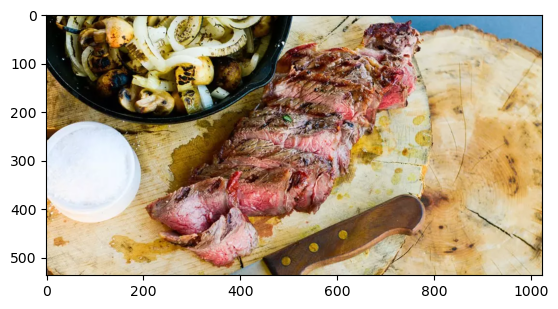

In [60]:
#show 2 random images from recipe_images
import random
from PIL import Image
import requests

url = random.choice(recipes_images)
image = Image.open(requests.get(url, stream=True).raw)
plt.imshow(image)
plt.show()


In [44]:
rp.get_steps(rp.get_recipes()['0'])

['Heat the oven and prepare for frying: Arrange a rack in the middle of the oven and heat to 375°F. Add enough oil to a wide, deep saucepan or pot so that it is 3/4-inch deep. If you have a deep-fry or candy thermometer, place it near the stove or attach it to the pan. Line a large platter with a few sheets of paper towels and set near the stove.',
 'Set up a breading station: Line up 3 shallow bowls or 8-inch square rimmed dishes side by side. Place the flour, 1 teaspoon of the salt, and 1/2 teaspoon of the black pepper in the first dish and mix to combine. Place the eggs, water, and remaining 1 teaspoon of the salt to the second dish and beat lightly with a fork to combine. Pour the breadcrumbs into the third dish.',
 'Pound the chicken: Place a large sheet of plastic wrap or wax paper on a work surface or cutting board and place 1 breast on it. Cover with a second piece of plastic wrap or wax paper. Using the flat side of a meat mallet or the bottom of a small saucepan, gently pound

In [52]:
recipe_steps = []
for key in rp.get_recipes():
    steps = rp.get_steps(rp.get_recipes()[key])
    #add the number of the step after every ', seen
    steps = [str(i+1) + ". " + steps[i] for i in range(len(steps))]
    recipe_steps.append(steps)



In [63]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to("mps")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = CLIPTokenizerFast.from_pretrained("openai/clip-vit-base-patch32")

image = Image.open(requests.get(url, stream=True).raw)
inputs = processor(text=["steak", "Chicken alfredo"], images=image, return_tensors="pt", padding=True).to("mps")

outputs = model(**inputs)
logits_per_image = outputs.logits_per_image
probs = logits_per_image.softmax(dim=1)


In [64]:
probs

tensor([[1.0000e+00, 1.8743e-06]], device='mps:0', grad_fn=<SoftmaxBackward0>)